In [ ]:
!pip install git+https://www.github.com/mouseland/cellpose.git

In [1]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.5.dev14+gc68d52e 
platform:       	linux 
python version: 	3.10.17 
torch version:  	2.7.0+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


2025-06-03 11:53:22,226 [INFO] WRITING LOG OUTPUT TO /home/grads/msa6093/.cellpose/run.log
2025-06-03 11:53:22,228 [INFO] 
cellpose version: 	4.0.5.dev14+gc68d52e 
platform:       	linux 
python version: 	3.10.17 
torch version:  	2.7.0+cu126
2025-06-03 11:53:22,414 [INFO] ** TORCH CUDA version installed and working. **
2025-06-03 11:53:22,416 [INFO] ** TORCH CUDA version installed and working. **
2025-06-03 11:53:22,417 [INFO] >>>> using GPU (CUDA)
2025-06-03 11:53:24,959 [INFO] >>>> loading model /home/grads/msa6093/.cellpose/models/cpsam


In [20]:
dir = "/scratch/msa6093/AndrewsData/ImageSlices/Z_axis"
dir = Path(dir)
if not dir.exists():
  raise FileNotFoundError("directory does not exist")

# *** change to your image extension ***
image_ext = ".tif"

# list all files
files = natsorted([f for f in dir.glob("*"+image_ext) if "_masks" not in f.name and "_flows" not in f.name])

if(len(files)==0):
  raise FileNotFoundError("no image files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} images in folder:")

for f in files:
  print(f.name)

256 images in folder:
slice-000_row-0000_col-0000.tif
slice-001_row-0000_col-0000.tif
slice-002_row-0000_col-0000.tif
slice-003_row-0000_col-0000.tif
slice-004_row-0000_col-0000.tif
slice-005_row-0000_col-0000.tif
slice-006_row-0000_col-0000.tif
slice-007_row-0000_col-0000.tif
slice-008_row-0000_col-0000.tif
slice-009_row-0000_col-0000.tif
slice-010_row-0000_col-0000.tif
slice-011_row-0000_col-0000.tif
slice-012_row-0000_col-0000.tif
slice-013_row-0000_col-0000.tif
slice-014_row-0000_col-0000.tif
slice-015_row-0000_col-0000.tif
slice-016_row-0000_col-0000.tif
slice-017_row-0000_col-0000.tif
slice-018_row-0000_col-0000.tif
slice-019_row-0000_col-0000.tif
slice-020_row-0000_col-0000.tif
slice-021_row-0000_col-0000.tif
slice-022_row-0000_col-0000.tif
slice-023_row-0000_col-0000.tif
slice-024_row-0000_col-0000.tif
slice-025_row-0000_col-0000.tif
slice-026_row-0000_col-0000.tif
slice-027_row-0000_col-0000.tif
slice-028_row-0000_col-0000.tif
slice-029_row-0000_col-0000.tif
slice-030_row-0000

In [33]:
image_idx = 2


img = io.imread(files[image_idx])

print(f'your image has shape: {img.shape}. Assuming channel dimension is last with {img.shape[-1]} channels')

your image has shape: (256, 256). Assuming channel dimension is last with 256 channels


In [34]:
first_channel = '0' # @param ['None', 0, 1, 2, 3, 4, 5]
second_channel = '1' # @param ['None', 0, 1, 2, 3, 4, 5]
third_channel = '2' # @param ['None', 0, 1, 2, 3, 4, 5]

2025-06-03 12:54:49,112 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-06-03 12:54:49,851 [WARNING] Resizing is depricated in v4.0.1+


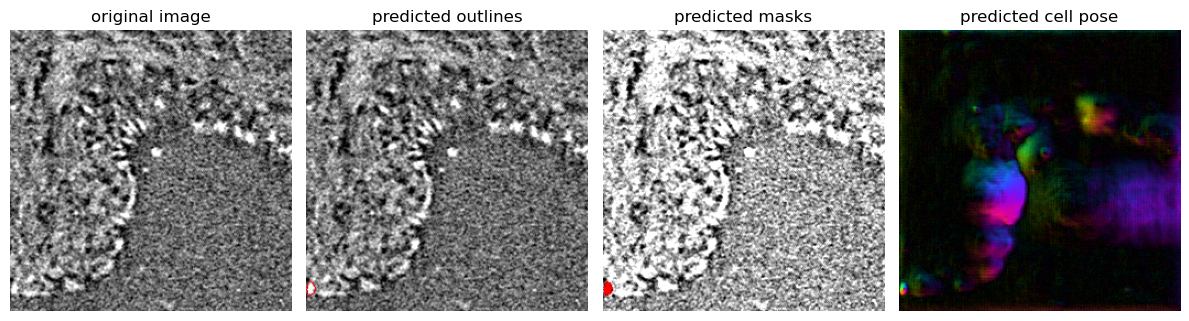

: 

In [ ]:
import numpy as np
from tifffile import imwrite
import nibabel as nib
import matplotlib.pyplot as plt
from cellpose import plot

# run Cellpose inference
masks, flows, styles = model.eval(
    img,               # 2D in → Cellpose treats it as (1,1,Y,X)
    batch_size=32,
    channels=[0, 0],   # single channel for both cyto & nuclei
    flow_threshold=100.0,
    cellprob_threshold=-100.0,
    diameter=10,
    normalize={"tile_norm_blocksize": 0}
)

# extract the mask
mask = masks[0] if isinstance(masks, (list, tuple)) else masks

out_base = "/scratch/msa6093/Daphnia392/CuratedTrainingData"

# save as .npy
np.save(f"{out_base}/predicted-X2000-{image_idx}.npy", mask)

# save as 16-bit TIFF
imwrite(f"{out_base}/predicted-X2000-{image_idx}.tif", mask.astype(np.uint16))

# save as NIfTI
nii = nib.Nifti1Image(mask, affine=np.eye(4))
nib.save(nii, f"{out_base}/predicted-X2000-{image_idx}.nii.gz")

# Plot
img_hwc = img[..., np.newaxis]   # (Y, X, 1)
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img_hwc, mask, flows[0])
plt.tight_layout()
plt.show()
